# Starter Notebook

Install and import required libraries

91.39% 83.75% smaller batch size, warmup, regularization, lower LR

In [1]:
# !pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19173 sha256=e0131f18875e3869c66e1cb750ab48793865ee1e1aa85c7e1cb7612917c6de85
  Stored in directory: /root/.cache/pip/wheels/47/50/9e/29dc79037d74c3c1bb4a8661fb608e8674b7e4260d6a3f8f51
Successfully built nvidia-ml-py3


In [2]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

2025-04-12 03:16:08.279326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744427768.501563      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744427768.565283      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Tokenizer and Preprocess Data

In [3]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [4]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [5]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [6]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=10000, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

print(train_dataset.shape)
print(eval_dataset.shape)

(110000, 3)
(10000, 3)


## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [7]:
!pip install peft accelerate transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found 

In [8]:
from peft import get_peft_model, LoraConfig, TaskType

# Configure LoRA
lora_config = LoraConfig(
    r=8,  # rank
    lora_alpha=16,
    target_modules=["query", "value"],  
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS  
)

# Wrap the model with PEFT
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [9]:
peft_model = get_peft_model(model, lora_config)
peft_model

/usr/local/lib/python3.11/dist-packages/peft/mapping.py:185: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'roberta-base' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): PeftModelForSequenceClassification(
      (base_model): LoraModel(
        (model): RobertaForSequenceClassification(
          (roberta): RobertaModel(
            (embeddings): RobertaEmbeddings(
              (word_embeddings): Embedding(50265, 768, padding_idx=1)
              (position_embeddings): Embedding(514, 768, padding_idx=1)
              (token_type_embeddings): Embedding(1, 768)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (encoder): RobertaEncoder(
              (layer): ModuleList(
                (0-11): 12 x RobertaLayer(
                  (attention): RobertaAttention(
                    (self): RobertaSdpaSelfAttention(
                      (query): lora.Linear(
                        (base_layer): Linear(in_features=768, out_features=768, bias=True)
                      

In [10]:
print("Trainable parameters:")
count = 0
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        count=count+1
        print(name)
print(count)

Trainable parameters:
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.2.attention.s

In [11]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 888,580 || all params: 125,537,288 || trainable%: 0.7078


## Training Setup

In [12]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [14]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./roberta-lora-agnews-v2",
    per_device_train_batch_size=8,          # smaller batch
    per_device_eval_batch_size=8,
    num_train_epochs=3,                    
    learning_rate=1e-5,                     # lower LR 
    weight_decay=0.01,                      # regularization to reduce overfitting
    warmup_ratio=0.1,                       # added warmup
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)



### Start Training

In [15]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Remove the unused argument before forwarding
        if "num_items_in_batch" in inputs:
            inputs.pop("num_items_in_batch")
        return super().compute_loss(model, inputs, return_outputs)


In [16]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  
    compute_metrics=compute_metrics,  
    data_collator=data_collator
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [17]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.340800,0.279026,0.908100
2,0.279000,0.263729,0.912100
3,0.245800,0.261859,0.913900


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=20625, training_loss=0.34730484935876094, metrics={'train_runtime': 10141.0244, 'train_samples_per_second': 32.541, 'train_steps_per_second': 2.034, 'total_flos': 5.635662032118067e+16, 'train_loss': 0.34730484935876094, 'epoch': 3.0})

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [18]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [19]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [20]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00


In [27]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm
import torch

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Returns:
        If labelled is True:
            - metrics (dict)
            - predictions (tensor)
            - true labels (tensor)
        Else:
            - predictions only
    """
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    all_labels = []

    if labelled:
        accuracy_metric = evaluate.load("accuracy")
        precision_metric = evaluate.load("precision")
        recall_metric = evaluate.load("recall")
        f1_metric = evaluate.load("f1")

    for batch in tqdm(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)

        all_predictions.append(predictions.cpu())

        if labelled:
            labels = batch["labels"].cpu()
            all_labels.append(labels)

            accuracy_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            precision_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            recall_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            f1_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())

    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        all_labels = torch.cat(all_labels, dim=0)

        eval_metric = {
            "accuracy": accuracy_metric.compute(),
            "precision": precision_metric.compute(average="macro"),
            "recall": recall_metric.compute(average="macro"),
            "f1": f1_metric.compute(average="macro"),
        }

        print("Evaluation Metrics:", eval_metric)
        return eval_metric, all_predictions, all_labels
    else:
        return all_predictions


In [28]:
metrics, predictions, labels = evaluate_model(
    model,
    eval_dataset,
    labelled=True,
    data_collator=data_collator
)

100%|██████████| 1250/1250 [03:06<00:00,  6.69it/s]


Evaluation Metrics: {'accuracy': {'accuracy': 0.9139}, 'precision': {'precision': 0.9137724000386551}, 'recall': {'recall': 0.9133416429141182}, 'f1': {'f1': 0.9132504496414808}}


In [31]:
from sklearn.metrics import classification_report

class_names = dataset.features["label"].names

print("\nPer-Class Metrics:\n")
print(classification_report(labels.numpy(), predictions.numpy(), target_names=class_names))



Per-Class Metrics:

              precision    recall  f1-score   support

       World       0.94      0.89      0.91      2530
      Sports       0.96      0.99      0.97      2528
    Business       0.88      0.87      0.87      2407
    Sci/Tech       0.88      0.91      0.89      2535

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [32]:
import matplotlib.pyplot as plt

def plot_per_class_f1(preds, labels, class_names):
    report = classification_report(
        labels.numpy(),
        preds.numpy(),
        target_names=class_names,
        output_dict=True
    )
    f1_scores = {cls: report[cls]["f1-score"] for cls in class_names}

    plt.figure(figsize=(10, 5))
    plt.bar(f1_scores.keys(), f1_scores.values())
    plt.ylim(0, 1)
    plt.ylabel("F1 Score")
    plt.title("Per-Class F1 Scores")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


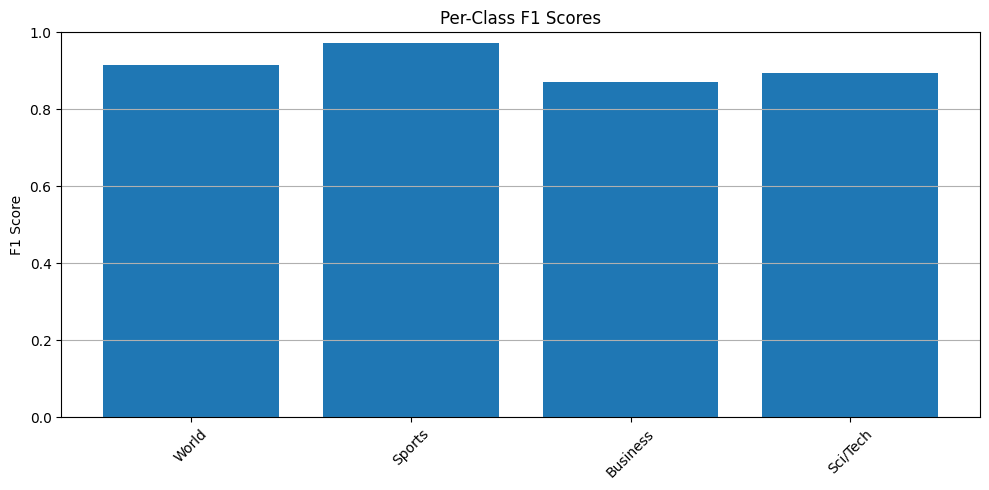

In [33]:
plot_per_class_f1(predictions, labels, class_names)


### Run Inference on unlabelled dataset

In [34]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [36]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join("inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [01:49<00:00,  9.10it/s]

Inference complete. Predictions saved to inference_output.csv
